In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




In [ ]:
#mount google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Dataset

In [ ]:
#load dataset
df = pd.read_csv('/content/drive/MyDrive/ML_twitter_dataset/twitter.csv', header=None, names=['tweet_record_id', 'entity', 'sentiment', 'tweet_description'])
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (74682, 4)
   tweet_record_id       entity sentiment  \
0             2401  Borderlands  Positive   
1             2401  Borderlands  Positive   
2             2401  Borderlands  Positive   
3             2401  Borderlands  Positive   
4             2401  Borderlands  Positive   

                                   tweet_description  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [ ]:
#consider only sentiment and tweet_description columns - drop unwanted columns
df = df[['sentiment', 'tweet_description']]
print("Data after dropping unwanted columns:")
print(df.head())

Data after dropping unwanted columns:
  sentiment                                  tweet_description
0  Positive  im getting on borderlands and i will murder yo...
1  Positive  I am coming to the borders and I will kill you...
2  Positive  im getting on borderlands and i will kill you ...
3  Positive  im coming on borderlands and i will murder you...
4  Positive  im getting on borderlands 2 and i will murder ...


#Data Cleaning

In [ ]:
#define a function to clean tweet text
def clean_text(text):
    #check if text is a string. if not return an empty string (error handling for non string values)
    if not isinstance(text, str):
        return ""
    #remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #remove mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    #remove special characters, numbers and punctuations by keeping only alphabets and spaces
    text = re.sub(r'[^A-Za-z\s]', '', text)
    #convert to lower case
    text = text.lower()
    #remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#apply the cleaning function to the tweet_description column
df['clean_tweet'] = df['tweet_description'].apply(clean_text)

print("Cleaned tweets:")
print(df[['tweet_description', 'clean_tweet']].head())



Cleaned tweets:
                                   tweet_description  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                         clean_tweet  
0  im getting on borderlands and i will murder yo...  
1  i am coming to the borders and i will kill you...  
2  im getting on borderlands and i will kill you all  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands and i will murder yo...  


In [ ]:
#remove any missing values if they exist
df.dropna(subset=['sentiment', 'clean_tweet'], inplace=True)
print("Data shape after dropping missing values:", df.shape)


Data shape after dropping missing values: (74682, 3)


In [ ]:
# Split the dataset into training and testing sets
X = df['clean_tweet']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 59745
Test set size: 14937


#Tokenization

In [ ]:
#tokenization using count vectorizer (Bag-of-Words approach)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#display the shape of the vectorized data
print("Shape of training vectors:", X_train_vec.shape)
print("Shape of testing vectors:", X_test_vec.shape)


Shape of training vectors: (59745, 34818)
Shape of testing vectors: (14937, 34818)


#Build model

In [ ]:
#build and train the Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

#predict on both training and testing sets
y_train_pred = nb_model.predict(X_train_vec)
y_test_pred = nb_model.predict(X_test_vec)

#evaluate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

#display accuracy values
print("Training Accuracy: {:.4f}".format(train_accuracy))
print("Testing Accuracy: {:.4f}".format(test_accuracy))
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.7800
Testing Accuracy: 0.7297

Classification Report on Test Data:
              precision    recall  f1-score   support

  Irrelevant       0.81      0.57      0.67      2598
    Negative       0.69      0.86      0.76      4509
     Neutral       0.80      0.60      0.69      3664
    Positive       0.70      0.81      0.75      4166

    accuracy                           0.73     14937
   macro avg       0.75      0.71      0.72     14937
weighted avg       0.74      0.73      0.72     14937



#Confusion matrix

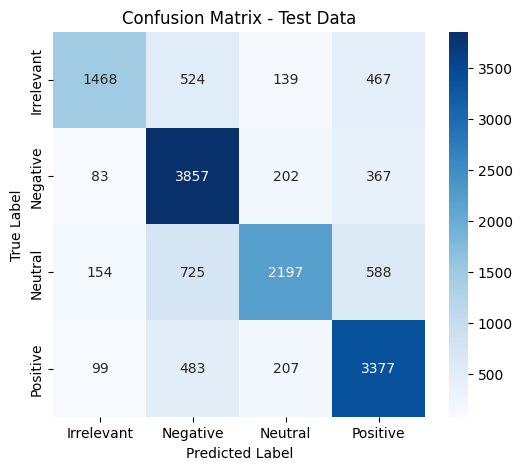

In [ ]:
#plot confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.show()

#Training and Validation Accuracy

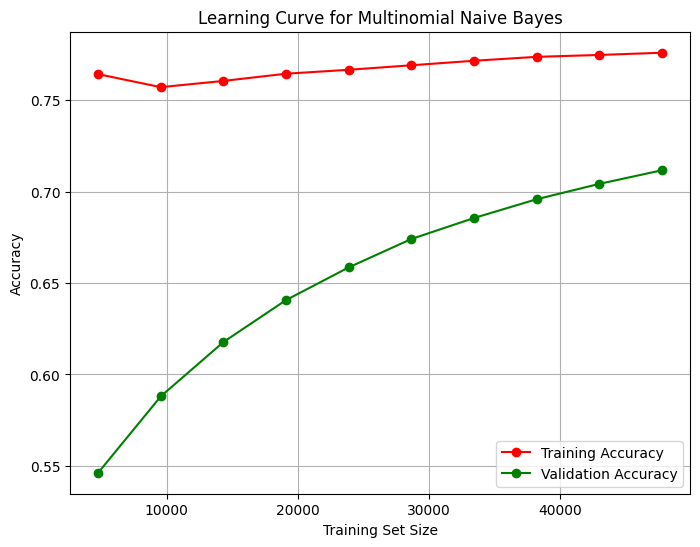

In [ ]:
#plot learning curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=MultinomialNB(),
    X=X_train_vec,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training Accuracy")
plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label="Validation Accuracy")
plt.title("Learning Curve for Multinomial Naive Bayes")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()
